In [1]:
import import_ipynb
import TSAnalyzer
import pandas as ps
import SQL_API
import globalConstants as gConst
import importlib
from trueskill import Rating, quality_1vs1, rate_1vs1
import WeightedSampling
import math
import numpy as np
from random import sample
from random import shuffle
import BiasEstimator
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

importing Jupyter notebook from TSAnalyzer.ipynb
importing Jupyter notebook from SQL_API.ipynb
importing Jupyter notebook from WeightedSampling.ipynb
importing Jupyter notebook from BiasEstimator.ipynb
importing Jupyter notebook from mTurkAnalyzer.ipynb


In [2]:
def loadScoresToTS_Analyzer(tsa,sqlAPI):
    for label in gConst.OUTCOME_LABELS:
        scores = sqlAPI.getTSRecords(label)
        tsa.loadScores(scores,label)

In [3]:
def predictVote(a,b,strength,label):
    RatingA = Rating(float(a[strength + '_mu_' + label]),float(a[strength + '_sigma_' + label]))
    RatingB = Rating(float(b[strength + '_mu_' + label]),float(b[strength + '_sigma_' + label]))
    pTie = quality_1vs1(RatingA,RatingB)
    intensity = (1-pTie)*50
    vote = 50+ intensity if RatingB.mu > RatingA.mu else 50-intensity
    return vote

In [4]:
def getPredictions(a,b,label):
    predictions = []
    for strength in ['slight','mod','strong']:
        predictions.append(predictVote(a,b,strength,label))
    # calc avg prediction
    predictions.append(sum(predictions)/3.0) 
    return(predictions)

In [5]:
def calcErrors(predictions,actual):
    err = []
    for pred in predictions:
        err.append(pred - actual)
    return err

In [6]:
def calcUrbanCat(img1Cat,img2Cat):
    #print("image 1 cat: %i, image2 cat: %i" % (img1Cat,img2Cat))
    if(int(img1Cat)==int(img2Cat)):
        return gConst.URBAN_CATEGORIES[int(img1Cat)]
    else:
        return gConst.URBAN_CATEGORIES[len(gConst.URBAN_CATEGORIES)-1]

In [7]:
def calcRMSEOneStratify(errDict):
    b = errDict[['binaryErr','catErr']]
    b = b.pow(2)
    b = b.mean()
    b = np.sqrt(b)
    return(b)

In [8]:
def calcRMSEOneLabel(errDict,stratify=[]):
    if(len(stratify)==0):
        errVals = calcRMSEOneStratify(errDict)
        return({'all':errVals})
    else:
        stratifyCats = list(set(errDict[stratify]))
        errStats = {}
        for stratifyCat in stratifyCats:
            dataSubset = errDict[errDict[stratify]==stratifyCat]
            errStats[stratifyCat] = calcRMSEOneStratify(dataSubset)
        return(errStats)

In [9]:
def calcOverallError(errDict):
    indexLabels,absBinary,absCat,relBinary,relCat = [],[],[],[],[]
    for label in gConst.OUTCOME_LABELS:
        errStats = calcRMSEOneLabel(errDict['abs_' + label])
        absBinary.append(errStats['all']['binaryErr'])
        absCat.append(errStats['all']['catErr'])
        errStats = calcRMSEOneLabel(errDict['rel_' + label])
        relBinary.append(errStats['all']['binaryErr'])
        relCat.append(errStats['all']['catErr'])
    outputDF = ps.DataFrame()
    outputDF['abs_binary_all'] = absBinary
    outputDF['abs_cat_all'] = absCat
    outputDF['rel_binary_all'] = relBinary
    outputDF['rel_cat_all'] = relCat
    outputDF.index = gConst.OUTCOME_LABELS
    return(outputDF)

In [10]:
def calcRMSEByUrbanCat(errDict,dF,measType):
    stratifyCats = ['Urban','Seattle','Rural','InterRegion']
    columnNames = []
    allArs = [[],[],[],[],[],[],[],[]]
    for label in gConst.OUTCOME_LABELS:
        errStats = calcRMSEOneLabel(errDict[measType + '_' + label],'compareCat')
        index = 0
        for cat in stratifyCats:
            for errType in ['binaryErr','catErr']:
                currArr = allArs[index]
                currArr.append(errStats[cat][errType])
                columnNames.append(measType + "_" + cat + "_" + errType)
                index+=1
    for index in range(0,len(allArs)):
        dF[columnNames[index]] = allArs[index]
    return(dF)

In [11]:
def calcRMSEByVoterRegion(errDict,dF,measType):
    allArs = [[],[],[],[],[],[],[],[]]
    stratifyCats = ['NorthEast','MidWest','South','West']
    columnNames = []
    for label in gConst.OUTCOME_LABELS:
        errStats = calcRMSEOneLabel(errDict[measType + '_' + label],'mtCat')
        index = 0
        for cat in stratifyCats:
            for errType in ['binaryErr','catErr']:
                print(errStats)
                currArr = allArs[index]
                currArr.append(errStats[cat][errType])
                columnNames.append(measType + "_" + cat + "_" + errType)
                index+=1
    for index in range(0,len(allArs)):
        dF[columnNames[index]] = allArs[index]
    return(dF)

In [12]:
def getErrs(record,label,tsa,absVal=True):
    lImg = record['l_img_' + label]
    rImg = record['r_img_' + label]
    lTS = tsa.getTSOneImageOneLabel(lImg,label)
    rTS = tsa.getTSOneImageOneLabel(rImg,label)
    predictions = getPredictions(lTS,rTS,label)
    if(absVal):
        actual = record['abs_cont_outcome_' + label]
    else:
        actual = record['rel_cont_outcome_' + label]
    binaryErr,catErr = calcErrors([predictions[0],predictions[3]],actual)
    urbanCat = calcUrbanCat(lTS['urban_cat'],rTS['urban_cat'])
    outcomeDict = {'binaryErr':binaryErr,'catErr':catErr,'compare_cat':urbanCat,'region':record['mt_region']}
    return(outcomeDict)

In [13]:
def calcErrsForLabel(recordSet,label,tsa,absVal):
    binaryErr, catErr,compareCat,mtCat = [],[],[],[]
    numRecords = len(recordSet['assign_id'])
    for index in range(len(recordSet['assign_id'])):
        tempRecord = recordSet.iloc[index]
        errResults = getErrs(tempRecord,label,tsa,absVal)    
        binaryErr.append(errResults['binaryErr'])
        catErr.append(errResults['catErr'])
        compareCat.append(errResults['compare_cat'])
        mtCat.append(errResults['region'])
    labelErrs = ps.DataFrame()
    labelErrs['binaryErr'] = binaryErr
    labelErrs['catErr'] = catErr
    labelErrs['compareCat'] = compareCat
    labelErrs['mtCat'] = mtCat
    return(labelErrs)

In [14]:
def translateLabels(inputLabels,toSurvey=True):
    tempLabels = OUTCOME_LABELS + QA_LABEL
    tempTranslation = LABEL_TRANSLATION + QA_TRANSLATION
    tempGrammar = LABEL_GRAMMAR + QA_GRAMMAR
    translatedLabels = []
    grammar = []
    for label in inputLabels:
        if(toSurvey):
            translatedLabels.append(tempTranslation[tempLabels.index(label)])
            grammar.append(tempGrammar[tempLabels.index(label)])
        else:
            translatedLabels.append(tempLabels[tempTranslation.index(label)])
        
    return([translatedLabels,grammar])

In [15]:
def insertMTToImageRecord(assign_id,imageid):
    insertString = 'INSERT INTO mt_to_image (assign_id,image_id) VALUES (%s,%s)'
    try:
        cur = connection.cursor()
        cur.execute(
            insertString, 
            (
                assign_id,
                imageid
            )
        )
        connection.commit()
        print("sucessfully commited insertion")
        print(str(imageid))
        cur.close()
    except Exception as e:
        print(str(e))
        connection.rollback()
        cur.close()

In [16]:
def insertMTRecord(assign_id,jsonRecord):
    nameString = 'INSERT INTO mt_votes (assign_id'
    valString = 'VALUES (%s'
    valArray = [assign_id]
    for label in jsonRecord['labels']:
        outcomeLabel = translateLabels([label],toSurvey=False)[0][0]
        currLabelIndex = jsonRecord['labels'].index(label)
        nameString = nameString + ',l_img_' + outcomeLabel + ',r_img_' + outcomeLabel + ',' + outcomeLabel + '_vote'
        valString += ',%s,%s,%s'
        valArray += [
            jsonRecord['idsLeft'][currLabelIndex],
            jsonRecord['idsRight'][currLabelIndex],
            jsonRecord['votes'][currLabelIndex]
        ]
    nameString += ') '
    valString += ')'
    insertString = nameString + valString
    try:
        cur = connection.cursor()
        cur.execute(
            insertString, 
            (
                valArray
            )
        )
        connection.commit()
        cur.close()
        return(True)
    except Exception as e:
        print(str(e))
        cur.close()
        connection.rollback()
        return(False)

In [17]:
def isCarVoteValid(leftCarImg,rightCarImg,carVote,GameModel):
    leftImgCat = GameModel.carImgSet.getCarCatByImgId(leftCarImg)
    if(leftImgCat == True):
        if(int(carVote) < 50):
            return(True)
        else:
            return(False)
    else:
        if(int(carVote) >50):
            return(True)
        else:
            return(False)

In [18]:
def convertVoteToOutcome(vote):
    vote = int(vote)
    if(vote==50):
        return(WeightedSampling.Outcomes('tie','tie','tie'))
    if(vote<50):
        #print("left side wins")
        if(vote<16):
            return(WeightedSampling.Outcomes('win','win','win'))
        if(vote<33):
            return(WeightedSampling.Outcomes('win','win','tie'))
        return(WeightedSampling.Outcomes('win','tie','tie'))
    else:
        #print("right side wins")
        if(vote>84):
            return(WeightedSampling.Outcomes('lose','lose','lose'))
        if(vote>67):
            return(WeightedSampling.Outcomes('lose','lose','tie'))
        return(WeightedSampling.Outcomes('lose','tie','tie'))

In [19]:
def updateTSScores(labels,lImgs,rImgs,votes,GameModel,angle):
    for index in range(len(labels)):
        currLabel = labels[index]
        if(currLabel != 'cars'):
            leftId = lImgs[index]
            rightId = rImgs[index]
            gameOutcome = convertVoteToOutcome(votes[index])
            GameModel.updateGame(currLabel,leftId,rightId,gameOutcome,angle)

In [20]:
def processMTRecord(labels,lImgs,rImgs,votes,angle,GameModel):
    if(isCarVoteValid(lImgs[4],rImgs[4],votes[4],GameModel)):
        updateTSScores(labels,lImgs,rImgs,votes,GameModel,angle)

In [21]:
def loadMTRecords(GameModel,rawRecords,measType='rel'):
    imgInfo = ps.read_csv(gConst.TS_SCORES)
    imgInfo = imgInfo[['image_id','angle']]
    straightImgs = imgInfo[imgInfo['angle']=='straight']
    sideImgs = imgInfo[imgInfo['angle']=='side']
    for recordIndex in range(len(rawRecords['assign_id'])):
        record = rawRecords.iloc[recordIndex]
        if(recordIndex % 500 == 0):
            print("prcoessed %i records " % (recordIndex))
        labels = ['greenspace','relax','safe','beauty','cars']
        lImgs = [record['l_img_greenspace'],
                 record['l_img_relax'],
                 record['l_img_safe'],
                 record['l_img_beauty'],
                 record['l_img_cars']
                ]
        rImgs = [record['r_img_greenspace'],
                 record['r_img_relax'],
                 record['r_img_safe'],
                 record['r_img_beauty'],
                 record['r_img_cars']
                ]
        votes = [record[measType + '_cont_outcome_greenspace'],
                 record[measType + '_cont_outcome_relax'],
                 record[measType + '_cont_outcome_safe'],
                 record[measType + '_cont_outcome_beauty'],
                 record['abs_cont_outcome_cars'],
                ]
        if(lImgs[0] in list(straightImgs['image_id'])):
            angle = 'straight'
        elif(lImgs[0] in list(sideImgs['image_id'])):
            angle = 'side'
        else:
            print("warning: no valid angle")
        processMTRecord(labels,lImgs,rImgs,votes,angle,GameModel)

In [22]:
def setupCrossValidationDB(recordsToTrain,db,absType):
    GameModelRel = WeightedSampling.MTGame(db,reset=True)
    loadMTRecords(GameModelRel,recordsToTrain,absType) 
    print("completed cross validation")

In [23]:
def performCrossValidation(recordsToTest,tsaA,tsaR):
    labels = gConst.OUTCOME_LABELS
    errDict = {}
    for label in labels:    
        print(label)
        errDict['abs_' + label] = calcErrsForLabel(recordsToTest,label,tsaA,True)
        print("finished absolute err check")
        errDict['rel_' + label] = calcErrsForLabel(recordsToTest,label,tsaR,False)
    return(errDict)

In [24]:
def performInModelEvaluation(testSet):
    tsaRel,sqlAPIRel,GameModelRel = setupCrossValidationDB(testSet)
    print("cross validation is setup ")
    errDict = performCrossValidation(testSet)
    return(calcOverallError(errDict))

In [25]:
def performCrossValidationForRegion(cleanRecords,region,absDB,relDB,sampleMatch=False,subRegion=False):
    # cross Validation for west
    if(len(region)>0):
        # test impact of size on performance
        if(sampleMatch):
            trainSet = cleanRecords[cleanRecords['mt_region']!=region]
            testSet = cleanRecords[cleanRecords['mt_region']==region]
            trainSetN = len(trainSet['mt_region'])
            trainSet = cleanRecords.sample(n=trainSetN)
        elif(region=='Random'):
            print("random validation")
            shuffledSet = cleanRecords.sample(frac=1)
            trainSet = shuffledSet.iloc[0:len(shuffledSet['mt_region'])-1500]
            testSet = shuffledSet.iloc[len(shuffledSet['mt_region'])-1500:]
        # create new model with subregion data only.
        elif(subRegion):
            trainSet = cleanRecords[cleanRecords['mt_region']==region]
            testSet = cleanRecords[cleanRecords['mt_region']==region]
        else:
            trainSet = cleanRecords[cleanRecords['mt_region']!=region]
            testSet = cleanRecords[cleanRecords['mt_region']==region]
    else:
        trainSet = cleanRecords
        testSet = cleanRecords
    print("n training: %i, n test: %i" % (len(trainSet['mt_region']),len(testSet['mt_region'])))
    setupCrossValidationDB(trainSet,absDB,'abs')
    setupCrossValidationDB(trainSet,relDB,'rel')
    #setupCrossValidationDB(trainSet,gConst.PG_SIM_REL_DB,'rel')
    sqlAPIAbs = SQL_API.SQL_API(absDB,gConst.PGUSER,gConst.PGPWORD)
    sqlAPIRel = SQL_API.SQL_API(relDB,gConst.PGUSER,gConst.PGPWORD)
    tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
    loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
    tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
    loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
    print("cross validation is setup for region %s" % (region))
    errDict = performCrossValidation(testSet,tsaAbs,tsaRel)
    return(calcOverallError(errDict))

In [26]:
#allDF = calcOverallError(errDict)
#calcRMSEByUrbanCat(errDict,allDF,'abs')
#calcRMSEByUrbanCat(errDict,allDF,'rel')
#calcRMSEByVoterRegion(errDict,allDF,'abs')
#calcRMSEByVoterRegion(errDict,allDF,'rel')

In [34]:
cleanRecords = ps.read_csv(gConst.MTURK_RECORDS_CLEANED).sort_values(by=['mt_submit'])
#fullEval = performCrossValidationForRegion(cleanRecords,[],gConst.PG_SIM_ABS_DB,gConst.PG_REL_DB)
westCV = performCrossValidationForRegion(
    cleanRecords,'West',gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB
)
#southCV = performCrossValidationForRegion(cleanRecords,'South',gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB)
#NE_CV = performCrossValidationForRegion(cleanRecords,'NorthEast',gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB)
#MW_CV = performCrossValidationForRegion(cleanRecords,'MidWest',gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB) 
noWest = cleanRecords[cleanRecords['mt_region']!='west']
west = cleanRecords[cleanRecords['mt_region']!='west']

n training: 6456, n test: 1629
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
com

In [ ]:
#westCV
#fullEval
#southCV
#NE_CV
MW_CV

In [31]:
csvFile = gConst.PARENT_FOLDER + label2 + "AllTsAbs.csv"
csvFile2 = gConst.PARENT_FOLDER + label2 + "AllTsRel.csv"
sqlAPIAbs = SQL_API.SQL_API(gConst.PGDB,gConst.PGUSER,gConst.PGPWORD)
sqlAPIRel = SQL_API.SQL_API(gConst.PG_REL_DB,gConst.PGUSER,gConst.PGPWORD)
tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
tsaRel.calcAvgTSAllLabels()
tsaAbs.calcAvgTSAllLabels()
b = tsaAbs.getCorMatrix()
b.to_csv(csvFile,index=False)
c = tsaRel.getCorMatrix()
c.to_csv(csvFile2,index=False)

completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
finished calculating avg ts scores for all labels
finished calculating avg ts scores for all labels


In [102]:
noWest = cleanRecords[cleanRecords['mt_region']!='West']
westCV = performCrossValidationForRegion(
    noWest,[],gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB,subRegion=False
)
mta = mTurkAnalyzer.MTurkAnalyzer(timeCutoff=30)
mta.setRecords(noWest)
mta.cleanRecords = noWest
sqlAPIAbs = SQL_API.SQL_API(gConst.PG_SIM_ABS_DB,gConst.PGUSER,gConst.PGPWORD)
sqlAPIRel = SQL_API.SQL_API(gConst.PG_SIM_REL_DB,gConst.PGUSER,gConst.PGPWORD)
tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
tsaAbs.calcAvgTSAllLabels()
tsaRel.calcAvgTSAllLabels()
beNoWest = BiasEstimator.BiasEstimator(mta,tsaAbs,tsaRel)
beNoWest.calcAvgImgBiasByRegionAllLabels()
noWestbiasDict = beNoWest.getBiasDict()
noWestbiasDict = deepcopy(noWestbiasDict)

n training: 6456, n test: 6456
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
com

In [103]:
west = cleanRecords[cleanRecords['mt_region']=='West']
westCV = performCrossValidationForRegion(
    west,[],gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB,subRegion=True
)
mta = mTurkAnalyzer.MTurkAnalyzer(timeCutoff=30)
mta.setRecords(west)
mta.cleanRecords = west
sqlAPIAbs = SQL_API.SQL_API(gConst.PG_SIM_ABS_DB,gConst.PGUSER,gConst.PGPWORD)
sqlAPIRel = SQL_API.SQL_API(gConst.PG_SIM_REL_DB,gConst.PGUSER,gConst.PGPWORD)
tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
tsaAbs.calcAvgTSAllLabels()
tsaRel.calcAvgTSAllLabels()
beWest = BiasEstimator.BiasEstimator(mta,tsaAbs,tsaRel)
beWest.calcAvgImgBiasByRegionAllLabels()
westbiasDict = beWest.getBiasDict()
westbiasDict = deepcopy(westbiasDict)

n training: 1629, n test: 1629
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
completed cross validation
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
completed cross validation
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
cross validation is setup for region []
greenspace
finished absolute err check
relax
finished absolute err check
safe
finished absolute err check
beauty
finished absolute err check
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspa

In [78]:
noWestbiasDict['greenspace_rel'].describe()

,bMean,bStd,avg_mu_greenspace,avg_sigma_greenspace,abs_mu_greenspace,n_greenspace
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.010610,18.850706,24.975275,2.873412,3.484468,10.760000
std,4.235312,4.641942,4.237199,0.406947,2.408905,2.892122
min,-14.765916,4.986191,13.419869,1.949726,0.004547,3.000000
25%,-2.548856,15.898723,21.783284,2.590274,1.478839,9.000000
50%,-0.123261,18.825196,25.214634,2.829695,3.181772,11.000000
75%,2.842707,21.827172,28.159218,3.097886,5.120096,13.000000
max,17.135713,36.898533,34.849858,4.417232,11.580131,22.000000


In [107]:
label = 'relax'
mergedSet = ps.merge(westbiasDict[label+"_rel"],noWestbiasDict[label+ '_rel'],how="inner",on=['image_id'])
mergedSet['t1'] = mergedSet['avg_mu_' + label +'_x'] -25
mergedSet['t1'] = mergedSet['t1'].abs()
mergedSet = mergedSet[mergedSet['t1']>0.01]
mergedSet['t1'] = mergedSet['avg_mu_' + label + '_y'] -25
mergedSet['t1'] = mergedSet['t1'].abs()
mergedSet = mergedSet[mergedSet['t1']>0.01]
mergedSet = mergedSet[mergedSet['n_' + label + "_x"] >=3]
mergedSet.corr()

,bMean_x,bStd_x,avg_mu_relax_x,avg_sigma_relax_x,abs_mu_relax_x,n_relax_x,bMean_y,bStd_y,avg_mu_relax_y,avg_sigma_relax_y,abs_mu_relax_y,n_relax_y,t1
bMean_x,1.000000,-0.011830,-0.225903,-0.014853,-0.067342,0.008951,0.078329,-0.028122,-0.262142,0.048350,0.000293,-0.023607,0.000293
bStd_x,-0.011830,1.000000,0.008000,-0.267754,-0.407772,0.065759,-0.031183,0.038271,0.028783,0.034707,-0.099816,-0.078263,-0.099816
avg_mu_relax_x,-0.225903,0.008000,1.000000,0.039553,0.029060,-0.053750,-0.180306,0.075328,0.595829,-0.036895,-0.107197,-0.002403,-0.107197
avg_sigma_relax_x,-0.014853,-0.267754,0.039553,1.000000,0.204665,-0.851613,0.007544,0.026320,0.022061,-0.079573,0.053491,0.081452,0.053491
abs_mu_relax_x,-0.067342,-0.407772,0.029060,0.204665,1.000000,0.052507,0.007980,-0.131203,-0.040720,0.083385,0.277469,-0.020326,0.277469
n_relax_x,0.008951,0.065759,-0.053750,-0.851613,0.052507,1.000000,0.024423,-0.035766,-0.023700,0.098182,-0.002734,-0.076982,-0.002734
bMean_y,0.078329,-0.031183,-0.180306,0.007544,0.007980,0.024423,1.000000,-0.053630,-0.188412,-0.093859,0.032199,0.090235,0.032199
bStd_y,-0.028122,0.038271,0.075328,0.026320,-0.131203,-0.035766,-0.053630,1.000000,0.143272,-0.359932,-0.530136,0.097868,-0.530136
avg_mu_relax_y,-0.262142,0.028783,0.595829,0.022061,-0.040720,-0.023700,-0.188412,0.143272,1.000000,-0.052414,-0.096329,-0.005592,-0.096329
avg_sigma_relax_y,0.048350,0.034707,-0.036895,-0.079573,0.083385,0.098182,-0.093859,-0.359932,-0.052414,1.000000,0.301748,-0.865146,0.301748


In [89]:
cleanRecords = ps.read_csv(gConst.MTURK_RECORDS_CLEANED).sort_values(by=['mt_submit'])
shuffledSet = cleanRecords.sample(frac=1)
trainSet = shuffledSet.iloc[0:len(shuffledSet['mt_region'])-1629]
testSet = shuffledSet.iloc[len(shuffledSet['mt_region'])-1629:]
print(testSet.head())

                           assign_id                  l_img_safe  \
1810  3S06PH7KSSOTZP4XH57XP6606S5D1C   9-b6dbl25O33lNix5K5scQ_92   
7451  39GAF6DQWSKFT64J8Q7RVSC79HNV1A  Wucw8CtgagVgpBZqg-_Sgg_244   
1957  326O153BMJISJQY9TT2CWQPUV2QDEE  FWIUqKUXSaDhUQqFSezVYw_358   
5329  38F71OA9GUGNTY4I1XLLXYXOHD3MFM   yPVs81uUP4sADVlEVNUSPg_61   
2477  35H6S234SBKT2YQ1851VMQ9P1RF65X   mCx7LthXcQ-KyAJNaicQcA_92   

                      r_img_safe                 l_img_relax  \
1810    dtz4IXkaHp7DtkLoiB3zcA_0   nNt6lJYgl-8jrLt0Xg8_eA_91   
7451  uYCIEfWIHwtV8ME9oM_c2g_106  8Ns-5Fzmdt_MY6tUDgUWaQ_172   
1957   A-xl_MxRbQrTOWpRGK7AUA_90  Kr74s9jlBDoY8dsSAi8qXg_180   
5329  1QIDSZqQ8L6lJCX4qdzyqw_179  _R-rwj1ZUVtshlQfnM5P2g_104   
2477  VyY1TrXcVLz8E1tR-5L5FQ_181   HCBj4pq4YfJeO4PPBffizw_91   

                     r_img_relax                l_img_beauty  \
1810   QfCSCaivklPQQtPmVGy5gA_41   Whz4ZBJuIE-i1WuUMPoMXQ_91   
7451  FQ1yY5B6ZdgjydN8DQIRPA_180  IIfYmdeAX7LltZCEnieuHA_271   
1957  sl1vn0dt

In [91]:
fullEval = performCrossValidationForRegion(
    trainSet,[],gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB,subRegion=False
)
mta = mTurkAnalyzer.MTurkAnalyzer(timeCutoff=30)
mta.setRecords(trainSet)
mta.cleanRecords = trainSet
sqlAPIAbs = SQL_API.SQL_API(gConst.PG_SIM_ABS_DB,gConst.PGUSER,gConst.PGPWORD)
sqlAPIRel = SQL_API.SQL_API(gConst.PG_SIM_REL_DB,gConst.PGUSER,gConst.PGPWORD)
tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
tsaAbs.calcAvgTSAllLabels()
tsaRel.calcAvgTSAllLabels()
beOutsideRandom = BiasEstimator.BiasEstimator(mta,tsaAbs,tsaRel)
beOutsideRandom.calcAvgImgBiasByRegionAllLabels()
outsideRandomDict = beOutsideRandom.getBiasDict()
outsideRandomDict = deepcopy(outsideRandomDict)

n training: 6456, n test: 6456
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
prcoessed 2000 records 
prcoessed 2500 records 
prcoessed 3000 records 
prcoessed 3500 records 
prcoessed 4000 records 
prcoessed 4500 records 
prcoessed 5000 records 
prcoessed 5500 records 
prcoessed 6000 records 
completed cross validation
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
com

In [93]:
fullEval = performCrossValidationForRegion(
    testSet,[],gConst.PG_SIM_ABS_DB,gConst.PG_SIM_REL_DB,subRegion=False
)
mta = mTurkAnalyzer.MTurkAnalyzer(timeCutoff=30)
mta.setRecords(testSet)
mta.cleanRecords = testSet
sqlAPIAbs = SQL_API.SQL_API(gConst.PG_SIM_ABS_DB,gConst.PGUSER,gConst.PGPWORD)
sqlAPIRel = SQL_API.SQL_API(gConst.PG_SIM_REL_DB,gConst.PGUSER,gConst.PGPWORD)
tsaRel = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaRel,sqlAPIRel)
tsaAbs = TSAnalyzer.TSAnalyzer(gConst.OUTCOME_LABELS)
loadScoresToTS_Analyzer(tsaAbs,sqlAPIAbs)
tsaAbs.calcAvgTSAllLabels()
tsaRel.calcAvgTSAllLabels()
beInsideRandom = BiasEstimator.BiasEstimator(mta,tsaAbs,tsaRel)
beInsideRandom.calcAvgImgBiasByRegionAllLabels()
insideRandomDict = beInsideRandom.getBiasDict()
insideRandomDict = deepcopy(insideRandomDict)

n training: 1629, n test: 1629
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
completed cross validation
prcoessed 0 records 
prcoessed 500 records 
prcoessed 1000 records 
prcoessed 1500 records 
completed cross validation
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
cross validation is setup for region []
greenspace
finished absolute err check
relax
finished absolute err check
safe
finished absolute err check
beauty
finished absolute err check
completed loading scores for label greenspace
completed loading scores for label relax
completed loading scores for label safe
completed loading scores for label beauty
completed loading scores for label greenspa

In [111]:
label = 'relax'
mergedSet = ps.merge(insideRandomDict[label+"_rel"],outsideRandomDict[label+ '_rel'],how="inner",on=['image_id'])
mergedSet['t1'] = mergedSet['avg_mu_' + label +'_x'] -25
mergedSet['t1'] = mergedSet['t1'].abs()
mergedSet = mergedSet[mergedSet['t1']>0.01]
mergedSet['t1'] = mergedSet['avg_mu_' + label + '_y'] -25
mergedSet['t1'] = mergedSet['t1'].abs()
mergedSet = mergedSet[mergedSet['t1']>0.01]
mergedSet = mergedSet[mergedSet['n_' + label + "_x"] >=3]
mergedSet.corr()

,bMean_x,bStd_x,avg_mu_relax_x,avg_sigma_relax_x,abs_mu_relax_x,n_relax_x,bMean_y,bStd_y,avg_mu_relax_y,avg_sigma_relax_y,abs_mu_relax_y,n_relax_y,t1
bMean_x,1.000000,0.039353,-0.192059,-0.004693,-0.037339,-0.017764,0.068259,0.011642,-0.216315,-0.022370,0.009537,0.018869,0.009537
bStd_x,0.039353,1.000000,0.016335,-0.293414,-0.453119,0.134864,-0.084910,0.038549,0.065978,-0.018991,-0.099948,-0.025116,-0.099948
avg_mu_relax_x,-0.192059,0.016335,1.000000,0.003189,0.015637,0.025340,-0.243612,0.058506,0.567996,-0.044637,-0.093380,0.019958,-0.093380
avg_sigma_relax_x,-0.004693,-0.293414,0.003189,1.000000,0.285906,-0.850912,0.046925,0.009411,0.004848,-0.023422,0.089828,0.058069,0.089828
abs_mu_relax_x,-0.037339,-0.453119,0.015637,0.285906,1.000000,-0.085973,0.082124,-0.077148,-0.039239,0.086922,0.247199,-0.011673,0.247199
n_relax_x,-0.017764,0.134864,0.025340,-0.850912,-0.085973,1.000000,-0.043409,0.014459,0.023293,0.023313,-0.052308,-0.031003,-0.052308
bMean_y,0.068259,-0.084910,-0.243612,0.046925,0.082124,-0.043409,1.000000,-0.038702,-0.242030,0.020030,0.072115,0.022566,0.072115
bStd_y,0.011642,0.038549,0.058506,0.009411,-0.077148,0.014459,-0.038702,1.000000,0.069044,-0.344702,-0.564912,0.047651,-0.564912
avg_mu_relax_y,-0.216315,0.065978,0.567996,0.004848,-0.039239,0.023293,-0.242030,0.069044,1.000000,0.051551,-0.078809,-0.059272,-0.078809
avg_sigma_relax_y,-0.022370,-0.018991,-0.044637,-0.023422,0.086922,0.023313,0.020030,-0.344702,0.051551,1.000000,0.368697,-0.840294,0.368697


In [3]:
biasWest = np.asarray([0.13,0.06,0.06,0.08])
biasRandom = np.asarray([0.18,0.01,0.07,0.07])
disagreeWest = np.asarray([0.10,0.06,0.03,0.04])
disagreeRandom = np.asarray([0.06,0.08,0.03,0.04])
muWest = np.asarray([0.66,0.42,0.55,0.60])
muRandom = np.asarray([0.64,0.44,0.57,0.57])
sigmaWest = np.asarray([-0.09,-0.05,-0.15,-0.08])
sigmaRandom = np.asarray([-0.08,0,-0.06,-0.02])
intensityWest = np.asarray([0.35,0.15,0.18,0.28])
intensityRandom = np.asarray([0.29,0.20,0.23,0.25])

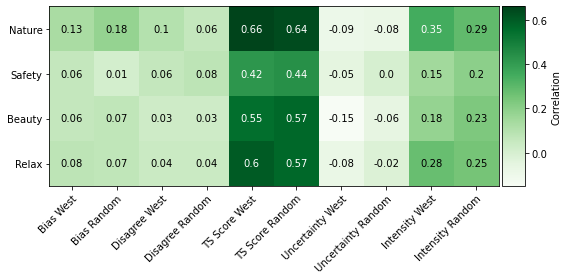

In [4]:
heatArray = np.transpose([
    biasWest,biasRandom,disagreeWest,disagreeRandom,muWest,muRandom,
    sigmaWest,sigmaRandom,intensityWest,intensityRandom
])


fig, ax = plt.subplots(figsize=(8,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right',size='5%',pad=0.05)
im = ax.imshow(heatArray,cmap="Greens")

fig.colorbar(im,cax=cax,orientation='vertical',label="Correlation")

attrLabels = ['Bias West', 'Bias Random','Disagree West','Disagree Random', 'TS Score West','TS Score Random',
            'Uncertainty West','Uncertainty Random','Intensity West','Intensity Random'
            ]

outcomeLabels = [
    'Nature','Safety','Beauty','Relax'
]
# We want to show all ticks...
ax.set_xticks(np.arange(len(attrLabels)))
ax.set_yticks(np.arange(len(outcomeLabels)))
# ... and label them with the respective list entries
ax.set_xticklabels(attrLabels)
ax.set_yticklabels(outcomeLabels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(outcomeLabels)):
    for j in range(len(attrLabels)):
        curCol = "black" if heatArray[i,j] < 0.3 else "w"
        text = ax.text(j, i, heatArray[i, j],
                        ha="center", va="center", color=curCol)
#ax.set_title("Moran's I by urban category and label")
fig.tight_layout()
plt.savefig(gConst.SENSITIVITY_FIG)
plt.show()